In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import heapq
import json
import numpy as np
import os
import random

In [2]:
unixbenchFilePath='../data/processed_files/unixbench.csv'
unixbenchData=pd.read_csv(unixbenchFilePath)

In [3]:
# 针对results_key这一列，计数每一行的值出现的次数
ResultsKeyCount = unixbenchData['results_key'].value_counts()
ResultsKeyCount = pd.DataFrame(ResultsKeyCount)
ResultsKeyCount.columns = ['number']

In [4]:
ResultsKeyCount.head()

,number
"gcc_oflag=O0,threads=1",19409
"gcc_oflag=O3,threads=1",10224
"gcc_oflag=O0,threads=cpu",4421
"gcc_oflag=O0,threads=fork",3914
"gcc_oflag=O0,threads=context",3857


In [5]:
unixbenchData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79786 entries, 0 to 79785
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   results_key  79786 non-null  object
 1   results      79786 non-null  object
 2   dimension    79786 non-null  object
dtypes: object(3)
memory usage: 1.8+ MB


In [6]:
# import pandas as pd
# import json

# # 创建示例数据框，包含一列dimension
# # df = pd.read_csv('../data/origin_files/key_test_t.csv')
# df = unixbenchData
# # 打印df的长度
# print(f"df length: {len(df)}")

# # 定义函数来检查字符串是否为ASCII编码
# def is_ascii(s):
#     return all(ord(c) < 128 for c in s)

# # 封装处理每一行的代码为一个函数
# def clean_row(row):
#     # 解析JSON字符串
#     try:
#         data = json.loads(row['dimension'])
#     except json.JSONDecodeError as e:
#         return None

#     # 遍历JSON数据中的每个值，检查是否为ASCII编码
#     for key, value in data.items():
#         if isinstance(value, str) and not is_ascii(value):
#             # 值包含乱码，删除该行
#             print(f"row {row.name} contains invalid value: {value}")
#             return None

#     # 返回清洗后的行
#     return row

# # 使用 apply 方法将 clean_row 函数应用到数据框的每一行上
# df_cleaned = df.apply(clean_row, axis=1)
# # 重置索引
# df_cleaned.reset_index(drop=True, inplace=True)

# # 打印处理后的数据框
# print(f"df length: {len(df_cleaned)}")


In [7]:
def getKeyNum(df):
    # 提取 results 列中带有 "#" 号的字段
    pattern = r'#\w+'  
    results = df['results'].str.cat(sep=' ')  # 将所有 results 列的数据合并为一个字符串
    hashtags = set(re.findall(pattern, results))  # 使用正则表达式提取带 "#" 号的字段，并去重

    # 统计每个带 "#" 号的字段在整个文件中出现的次数
    hashtags_dict = {}
    for hashtag in hashtags:
        count = results.count(hashtag)
        hashtags_dict[hashtag] = count
    return hashtags_dict

def showKeyNum(hashtags_dict):
    # 将字典按值从大到小排序
    hashtags_dict_sorted = sorted(hashtags_dict.items(), key=lambda x: x[1], reverse=True)

    # 提取排序后的键和值
    hashtags_sorted = [item[0] for item in hashtags_dict_sorted]
    counts_sorted = [item[1] for item in hashtags_dict_sorted]

    # 绘制柱状图
    plt.figure(figsize=(30, 10))  
    plt.bar(hashtags_sorted, counts_sorted)
    # 在柱状图上添加数值标签
    for a, b in zip(hashtags_sorted, counts_sorted):
        plt.text(a, b+0.05, '%.0f' % b, ha='center', va='bottom', fontsize=11)
    plt.xticks(rotation=90)  
    plt.xlabel('Hashtags')  
    plt.ylabel('Counts')  
    plt.title('Hashtags Counts')  
    plt.show()

def getTop10Key(hashtags_dict):
    # 获取字典中数量前十的字段
    top_n = 10  # 自定义获取前几个字段
    top_n_fields = heapq.nlargest(top_n, hashtags_dict, key=hashtags_dict.get)
    
    print("数量前十的字段：")
    for field in top_n_fields:
        print("字段名: {:<30s} 出现次数: {:d}".format(field, hashtags_dict[field]))

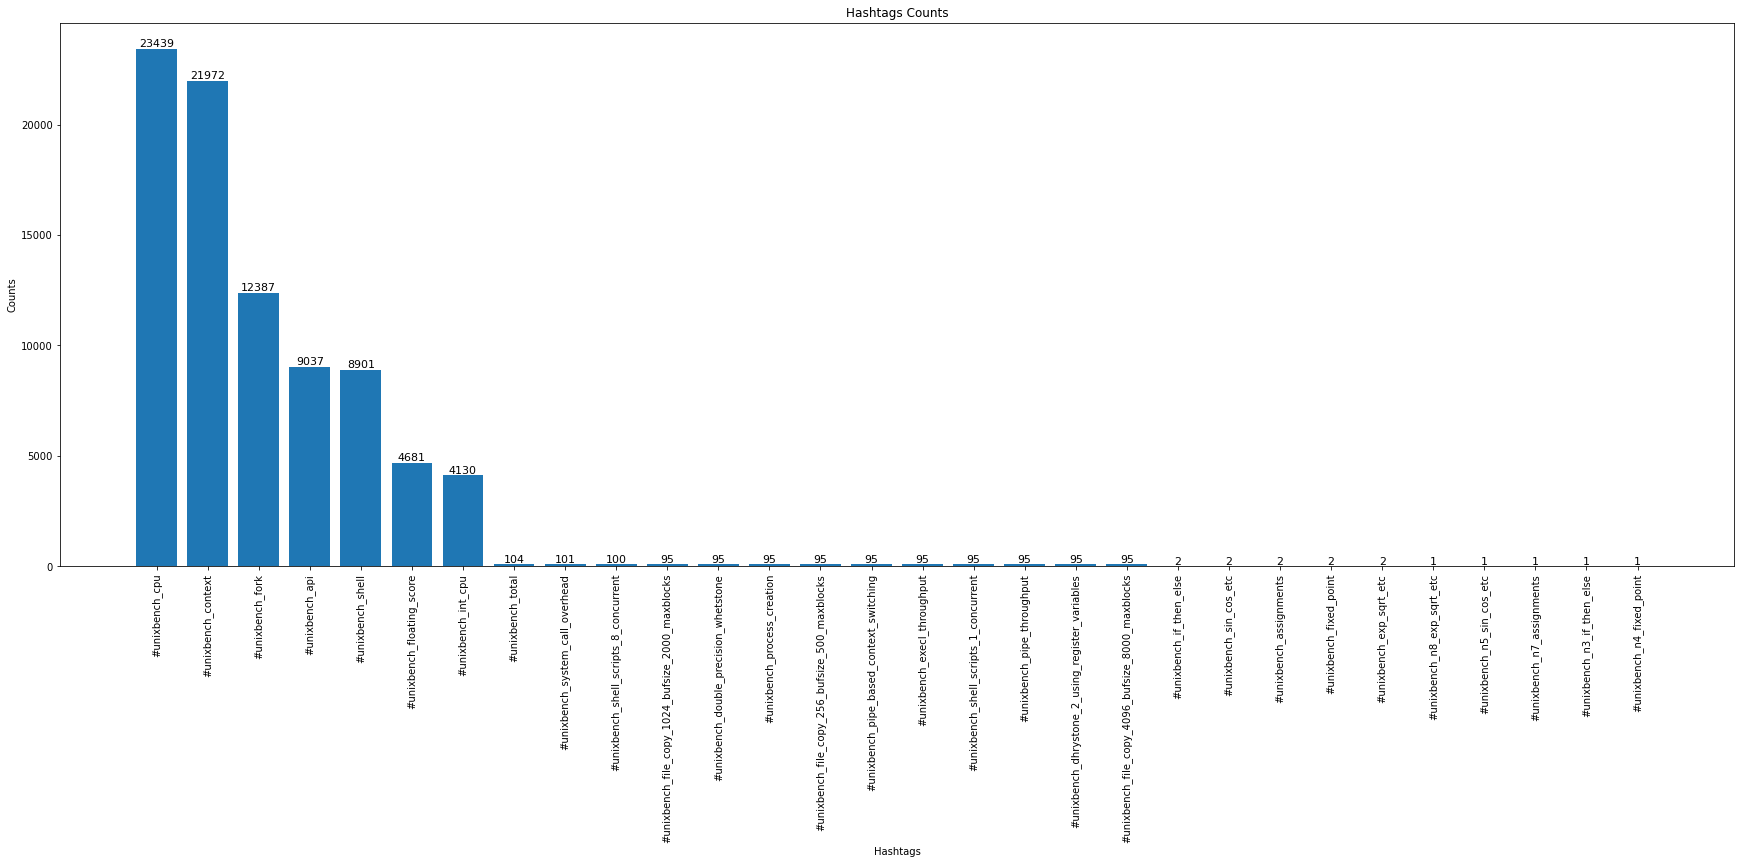

In [8]:
showKeyNum(getKeyNum(unixbenchData))

In [9]:
getTop10Key(getKeyNum(unixbenchData))

数量前十的字段：
字段名: #unixbench_cpu                 出现次数: 23439
字段名: #unixbench_context             出现次数: 21972
字段名: #unixbench_fork                出现次数: 12387
字段名: #unixbench_api                 出现次数: 9037
字段名: #unixbench_shell               出现次数: 8901
字段名: #unixbench_floating_score      出现次数: 4681
字段名: #unixbench_int_cpu             出现次数: 4130
字段名: #unixbench_total               出现次数: 104
字段名: #unixbench_system_call_overhead 出现次数: 101
字段名: #unixbench_shell_scripts_8_concurrent 出现次数: 100


In [10]:
def get_input_output_Speed(Tdf, field, keys_to_extract):
    # 选择需要提取的字段
    df = Tdf.copy()
    
    # 对dimension列进行预处理
    df['dimension'] = df['dimension'].apply(lambda x: json.loads(x))
    for key in keys_to_extract:
        df[key] = df['dimension'].apply(lambda x: 'None' if x.get(key) in [None, ''] else x.get(key))

    # 对cvm_cpu进行数值化处理
    df['cvm_cpu'] = df['cvm_cpu'].apply(pd.to_numeric, errors='coerce').fillna(-1)
    # 对cvm_memory进行数值化处理，通过正则表达式提取出数字
    df['cvm_memory'] = df['cvm_memory'].apply(lambda x: re.findall(r'\d+', x)[0] if re.findall(r'\d+', x) else '').apply(pd.to_numeric, errors='coerce').fillna(-1)

    # 筛选出符合要求的行
    df_filtered = df[df['results'].str.contains(field)]

    # 从results中提取出field对应的值
    df_output = pd.DataFrame(df_filtered['results'].apply(lambda x: json.loads(x)).tolist(), index=df_filtered.index)
    df_output = df_output[field]

    # 将input和output分别转成dataframe
    df_input = df_filtered[keys_to_extract + ['results_key']]
    df_output = pd.DataFrame(df_output)

    # 将input和output合并成一个dataframe
    df_result = df_input.join(df_output)
    df_result = df_result.reset_index(drop=True)

    return df_result

In [11]:
your_field = '#unixbench_cpu'
keys_to_extract = ['cvm_cpu', 'cvm_memory', 'cvm_cpu_qos', 'cvm_os_type', 'cvm_cpu_type', 'cvm_version','cvm_gpu_type','host_cpu_type','host_memory_type','tool_version','component_version','host_manufacturer_name','host_type']
# keys_to_extract = ['cvm_cpu', 'cvm_memory', 'cvm_cpu_qos', 'cvm_os_type', 'cvm_cpu_type', 'cvm_version','cvm_gpu_type','host_cpu_type','host_memory_type']
df_result = get_input_output_Speed(unixbenchData, your_field, keys_to_extract)

In [12]:
df_result.head()

,cvm_cpu,cvm_memory,cvm_cpu_qos,cvm_os_type,cvm_cpu_type,cvm_version,cvm_gpu_type,host_cpu_type,host_memory_type,tool_version,component_version,host_manufacturer_name,host_type,results_key,#unixbench_cpu
0,8.0,40.0,False,CentOS Linux release 7.3.1611 (Core),name_45,name_48,name_46,name_47,name_49,5.1.3,default,name_50,Y0-GT33-25G,"gcc_oflag=O0,threads=1",2364
1,8.0,40.0,False,CentOS Linux release 7.3.1611 (Core),name_45,name_48,name_46,name_47,name_49,5.1.3,default,name_50,Y0-GT33-25G,"gcc_oflag=O0,threads=8",18835
2,124.0,424.0,True,CentOS Linux release 8.2.2004 (Core),name_0,name_17,None,name_0,name_18,5.1.3a,default,name_3,None,"gcc_oflag=O0,threads=1",3265
3,124.0,424.0,True,CentOS Linux release 8.2.2004 (Core),name_0,name_17,None,name_0,name_18,5.1.3a,default,name_3,None,"gcc_oflag=O0,threads=124",317646
4,124.0,424.0,True,CentOS Linux release 8.2.2004 (Core),name_0,name_17,None,name_0,name_18,5.1.3a,default,name_3,None,"gcc_oflag=O3,threads=124",788652


In [13]:
# 将df_result保存到csv文件中
# df_result.to_csv('../data/processed_files/unixbench_cpu_new_data.csv', index=False, encoding='utf-8-sig')

In [14]:
print(df_result.shape)

(23439, 15)


In [15]:
# # 随机选取10条数据存入validation中，并从df_result中删除这10条数据
# validation = df_result.sample(n=2000, random_state=1)
# validation = pd.DataFrame(validation)
# df_result.drop(validation.index.values, inplace=True)

# # 取validation中的一条数据，判断是否能从df_result中找到相同的数据
# def find_same_data(validation, df_result, your_field):
#     # 随机选取一条数据
#     validation_data = validation.sample(n=1, random_state=1)
#     validation_data = pd.DataFrame(validation_data)

#     df_result_data = df_result.loc[
#         (df_result['cvm_cpu'] == validation_data['cvm_cpu'].values[0]) &
#         (df_result['cvm_memory'] == validation_data['cvm_memory'].values[0]) &
#         (df_result['cvm_cpu_qos'] == validation_data['cvm_cpu_qos'].values[0]) &
#         (df_result['cvm_os_type'] == validation_data['cvm_os_type'].values[0]) &
#         (df_result['results_key'] == validation_data['results_key'].values[0]) &
#         (df_result[your_field] == validation_data[your_field].values[0])
#     ]

#     if df_result_data.empty:
#         print("未找到相同的数据！")
#     else:
#         print("找到相同的数据！")

# find_same_data(validation, df_result, your_field)

In [16]:
# validation.head()

In [17]:
# 将df_result中的数据分成inPutDF和outPutDF两个dataframe
tempKey = keys_to_extract.copy()
tempKey.append('results_key')
print(keys_to_extract)
print(tempKey)

['cvm_cpu', 'cvm_memory', 'cvm_cpu_qos', 'cvm_os_type', 'cvm_cpu_type', 'cvm_version', 'cvm_gpu_type', 'host_cpu_type', 'host_memory_type', 'tool_version', 'component_version', 'host_manufacturer_name', 'host_type']
['cvm_cpu', 'cvm_memory', 'cvm_cpu_qos', 'cvm_os_type', 'cvm_cpu_type', 'cvm_version', 'cvm_gpu_type', 'host_cpu_type', 'host_memory_type', 'tool_version', 'component_version', 'host_manufacturer_name', 'host_type', 'results_key']


In [18]:
inPutDF = df_result[tempKey]
outPutDF = df_result[your_field]

In [19]:
print(inPutDF.shape)
print(outPutDF.shape)

(23439, 14)
(23439,)


In [20]:
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import learning_curve

In [21]:
def showPic(methodName, y_test, y_pred):
    # 创建柱状图
    plt.figure(figsize=(80, 15))

    plt.subplot(1, 2, 1)
    # 创建样本索引数组
    index = np.arange(len(y_test))
    # 绘制线性回归模型的折线图
    plt.plot(index, y_test, label='True Values')
    plt.plot(index, y_pred, label='Predicted Values')
    plt.xlabel('Sample Index')
    plt.ylabel('Values')
    plt.title('{}: True Values vs. Predicted Values'.format(methodName))
    plt.legend()
    plt.show()


def showCoef(linear_reg, decision_tree_reg, random_forest_reg):
    # 绘制特征重要性条形图
    if len(linear_reg.coef_) > 1:
        coef_abs = np.abs(linear_reg.coef_)
        sorted_idx = np.argsort(coef_abs)
        plt.figure(figsize=(150, 20))
        plt.bar(range(len(coef_abs)), coef_abs[sorted_idx])
        plt.xticks(range(len(coef_abs)), sorted_idx)
        plt.xlabel('Feature Index')
        plt.ylabel('Feature Importance (by coefficient absolute value)')
        plt.title('Linear Regression - Feature Importance')
        plt.show()
    else:
        print('Linear Regression - No feature importance to plot')

    if len(decision_tree_reg.feature_importances_) > 1:
        feature_importances = decision_tree_reg.feature_importances_
        sorted_idx = np.argsort(feature_importances)
        plt.figure(figsize=(150, 20))
        plt.bar(range(len(feature_importances)), feature_importances[sorted_idx])
        plt.xticks(range(len(feature_importances)), sorted_idx)
        plt.xlabel('Feature Index')
        plt.ylabel('Feature Importance')
        plt.title('Decision Tree - Feature Importance')
        plt.show()
    else:
        print('Decision Tree - No feature importance to plot')

    if len(random_forest_reg.feature_importances_) > 1:
        feature_importances = random_forest_reg.feature_importances_
        sorted_idx = np.argsort(feature_importances)
        plt.figure(figsize=(150, 20))
        plt.bar(range(len(feature_importances)), feature_importances[sorted_idx])
        plt.xticks(range(len(feature_importances)), sorted_idx)
        plt.xlabel('Feature Index')
        plt.ylabel('Feature Importance')
        plt.title('Random Forest - Feature Importance')
        plt.show()
    else:
        print('Random Forest - No feature importance to plot')


def getCoef(linear_reg, decison_tree_reg, random_forest_reg):
    result = []
    if len(linear_reg.coef_) > 1:
        coef_abs = np.abs(linear_reg.coef_)
        sorted_idx = np.argsort(coef_abs)
        # 将最后10个特征的索引存入templist中
        templist = []
        for i in range(1, 11):
            templist.append(sorted_idx[-i])
        result.append(templist)
    else:
        result.append([])
    if len(decison_tree_reg.feature_importances_) > 1:
        feature_importances = decison_tree_reg.feature_importances_
        sorted_idx = np.argsort(feature_importances)
        # 将最后10个特征的索引存入templist中
        templist = []
        for i in range(1, 11):
            templist.append(sorted_idx[-i])
        result.append(templist)
    else:
        result.append([])
    if len(random_forest_reg.feature_importances_) > 1:
        feature_importances = random_forest_reg.feature_importances_
        sorted_idx = np.argsort(feature_importances)
        # 将最后10个特征的索引存入templist中
        templist = []
        for i in range(1, 11):
            templist.append(sorted_idx[-i])
        result.append(templist)
    else:
        result.append([])
    return result


def getFeatureName(result, inputDF):
    feature_names = inputDF.columns
    linear_reg_indices = result[0]  # 线性回归模型的特征索引
    decision_tree_indices = result[1]  # 决策树模型的特征索引
    random_forest_indices = result[2]  # 随机森林模型的特征索引

    linear_reg_feature_names = feature_names[linear_reg_indices].tolist()  # 线性回归模型的特征列名列表
    decision_tree_feature_names = feature_names[decision_tree_indices].tolist()  # 决策树模型的特征列名列表
    random_forest_feature_names = feature_names[random_forest_indices].tolist()  # 随机森林模型的特征列名列表
    
    linear_reg_features = inputDF[linear_reg_feature_names]  # 线性回归模型的特征值
    decision_tree_features = inputDF[decision_tree_feature_names]  # 决策树模型的特征值
    random_forest_features = inputDF[random_forest_feature_names]  # 随机森林模型的特征值


def showDecisonTree(decision_tree_reg, flag=False):
    if flag:    
        plt.figure(figsize=(20, 10))  # 设置画布大小
        plot_tree(decision_tree_reg, max_depth=2, feature_names=None, filled=True, rounded=True)  # 设置最大深度为2，可以根据需要调整
        plt.title('Decision Tree')
        plt.show()


def showRandomForest(random_forest_reg, flag=False):
    if flag:
        if len(random_forest_reg.feature_importances_) > 1:
            # 获取特征重要性
            feature_importances = random_forest_reg.feature_importances_
            # 选择特征重要性最高的决策树
            best_tree_index = np.argmax(feature_importances)
            if best_tree_index >= random_forest_reg.n_estimators:
                best_tree_index = random_forest_reg.n_estimators - 1

            plt.figure(figsize=(20, 10))
            plot_tree(random_forest_reg.estimators_[best_tree_index], max_depth=2, feature_names=None, filled=True, rounded=True)
            plt.title('Best Decision Tree')
            plt.show()
        else:
            print('Random Forest - No feature importance to plot')


def getModel(X_train, y_train, save_path):
    # 初始化模型
    linear_reg = LinearRegression()
    decision_tree_reg = DecisionTreeRegressor()
    random_forest_reg = RandomForestRegressor(n_estimators=100, max_depth=5)
    svm_reg = SVR(C=1.0, epsilon=0.1)
    knn_reg = KNeighborsRegressor(n_neighbors=7, weights='uniform')

    # 拟合模型
    linear_reg.fit(X_train, y_train)
    decision_tree_reg.fit(X_train, y_train)
    random_forest_reg.fit(X_train, y_train)
    svm_reg.fit(X_train, y_train)
    knn_reg.fit(X_train, y_train)

    # 保存模型
    models = {
        'linear_reg': linear_reg,
        'decision_tree_reg': decision_tree_reg,
        'random_forest_reg': random_forest_reg,
        'svm_reg': svm_reg,
        'knn_reg': knn_reg
    }
    for model_name, model in models.items():
        with open(save_path + model_name + '.pkl', 'wb') as f:
            pickle.dump(model, f)

    return linear_reg, decision_tree_reg, random_forest_reg, svm_reg, knn_reg


def train(X, y, save_path):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    
    # 获取模型
    linear_reg, decision_tree_reg, random_forest_reg, svm_reg, knn_reg = getModel(X_train, y_train, save_path)
    
    # 将X_train, y_train划分为训练集和验证集
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

    # 验证效果（出现过的数据）
    print('验证效果（出现过的数据）')
    # 验证
    y_val_linear_reg = linear_reg.predict(X_val)
    y_val_decision_tree_reg = decision_tree_reg.predict(X_val)
    y_val_random_forest_reg = random_forest_reg.predict(X_val)
    y_val_svm_reg = svm_reg.predict(X_val)
    y_val_knn_reg = knn_reg.predict(X_val)

    # 计算评估指标
    r2_linear_reg_val = r2_score(y_val, y_val_linear_reg)
    r2_decision_tree_reg_val = r2_score(y_val, y_val_decision_tree_reg)
    r2_random_forest_reg_val = r2_score(y_val, y_val_random_forest_reg)
    r2_svm_reg_val = r2_score(y_val, y_val_svm_reg)
    r2_knn_reg_val = r2_score(y_val, y_val_knn_reg)

    print('{:<30} {:>10}'.format('Linear Regression R2:', '{:.8f}'.format(r2_linear_reg_val)))
    print('{:<30} {:>10}'.format('Decision Tree R2:', '{:.8f}'.format(r2_decision_tree_reg_val)))
    print('{:<30} {:>10}'.format('Random Forest R2:', '{:.8f}'.format(r2_random_forest_reg_val)))
    print('{:<30} {:>10}'.format('SVM R2:', '{:.8f}'.format(r2_svm_reg_val)))
    print('{:<30} {:>10}'.format('KNN R2:', '{:.8f}'.format(r2_knn_reg_val)))
    print('\n')

    # 用R^2判断模型的拟合程度，MAPE判断预测值的误差。较好模型的R^2应高于0.8，或者MAPE低于5%
    # 计算MAPE指标  越接近0模型越好,大于1就是劣质模型
    Linear_MAPE = mean_absolute_percentage_error(y_val, y_val_linear_reg)
    Decision_tree_MAPE = mean_absolute_percentage_error(y_val, y_val_decision_tree_reg)
    Random_forest_MAPE = mean_absolute_percentage_error(y_val, y_val_random_forest_reg)
    Svm_MAPE = mean_absolute_percentage_error(y_val, y_val_svm_reg)
    Knn_MAPE = mean_absolute_percentage_error(y_val, y_val_knn_reg)

    print('{:<30} {:>10}'.format('Linear Regression MAPE:', '{:.8f}'.format(Linear_MAPE)))
    print('{:<30} {:>10}'.format('Decision Tree MAPE:', '{:.8f}'.format(Decision_tree_MAPE)))
    print('{:<30} {:>10}'.format('Random Forest MAPE:', '{:.8f}'.format(Random_forest_MAPE)))
    print('{:<30} {:>10}'.format('SVM MAPE:', '{:.8f}'.format(Svm_MAPE)))
    print('{:<30} {:>10}'.format('KNN MAPE:', '{:.8f}'.format(Knn_MAPE)))
    print('\n\n')




    # 测试效果（没出现过的数据）
    print('测试效果（没出现过的数据）')
    # 预测
    y_pred_linear_reg = linear_reg.predict(X_test)
    y_pred_decision_tree_reg = decision_tree_reg.predict(X_test)
    y_pred_random_forest_reg = random_forest_reg.predict(X_test)
    y_pred_svm_reg = svm_reg.predict(X_test)
    y_pred_knn_reg = knn_reg.predict(X_test)

    # 计算评估指标
    r2_linear_reg = r2_score(y_test, y_pred_linear_reg)
    r2_decision_tree_reg = r2_score(y_test, y_pred_decision_tree_reg)
    r2_random_forest_reg = r2_score(y_test, y_pred_random_forest_reg)
    r2_svm_reg = r2_score(y_test, y_pred_svm_reg)
    r2_knn_reg = r2_score(y_test, y_pred_knn_reg)

    print('{:<30} {:>10}'.format('Linear Regression R2:', '{:.8f}'.format(r2_linear_reg)))
    print('{:<30} {:>10}'.format('Decision Tree R2:', '{:.8f}'.format(r2_decision_tree_reg)))
    print('{:<30} {:>10}'.format('Random Forest R2:', '{:.8f}'.format(r2_random_forest_reg)))
    print('{:<30} {:>10}'.format('SVM R2:', '{:.8f}'.format(r2_svm_reg)))
    print('{:<30} {:>10}'.format('KNN R2:', '{:.8f}'.format(r2_knn_reg)))
    print('\n')

    # 用R^2判断模型的拟合程度，MAPE判断预测值的误差。较好模型的R^2应高于0.8，或者MAPE低于5%
    # 计算MAPE指标  越接近0模型越好,大于1就是劣质模型
    Linear_MAPE = mean_absolute_percentage_error(y_test, y_pred_linear_reg)
    Decision_tree_MAPE = mean_absolute_percentage_error(y_test, y_pred_decision_tree_reg)
    Random_forest_MAPE = mean_absolute_percentage_error(y_test, y_pred_random_forest_reg)
    Svm_MAPE = mean_absolute_percentage_error(y_test, y_pred_svm_reg)
    Knn_MAPE = mean_absolute_percentage_error(y_test, y_pred_knn_reg)

    print('{:<30} {:>10}'.format('Linear Regression MAPE:', '{:.8f}'.format(Linear_MAPE)))
    print('{:<30} {:>10}'.format('Decision Tree MAPE:', '{:.8f}'.format(Decision_tree_MAPE)))
    print('{:<30} {:>10}'.format('Random Forest MAPE:', '{:.8f}'.format(Random_forest_MAPE)))
    print('{:<30} {:>10}'.format('SVM MAPE:', '{:.8f}'.format(Svm_MAPE)))
    print('{:<30} {:>10}'.format('KNN MAPE:', '{:.8f}'.format(Knn_MAPE)))
    print('\n')

    models = ['Linear Regression', 'Decision Tree Regression', 'Random Forest Regression', 'SVM Regression', 'KNN Regression']
    y_pred = ['y_pred_linear_reg', 'y_pred_decision_tree_reg', 'y_pred_random_forest_reg', 'y_pred_svm_reg', 'y_pred_knn_reg']
    # for i in range(len(models)):
    #     showPic(models[i], y_test, eval(y_pred[i]))

    return linear_reg, decision_tree_reg, random_forest_reg, svm_reg, knn_reg


def plot_learning_curve(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # 判断过拟合
    if train_scores_mean.all() < test_scores_mean.all():
        print("模型可能存在过拟合的问题\n\n")
    else:
        print("模型可能没有过拟合的问题\n\n")

    #画图
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
    label="Cross-validation score")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1,color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.1,color="g")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()


def judgeResult(model, X_train, y_train, X_test, y_test):
    # 在训练集和测试集上计算评估指标
    y_train = y_train.values
    y_test = y_test.values
    y_train = y_train.ravel()
    y_test = y_test.ravel()

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    print('Model: {}'.format(model.__class__.__name__))
    print('{:<30} {:>10}'.format('Train R2:', '{:.8f}'.format(r2_train)))
    print('{:<30} {:>10}'.format('Test R2:', '{:.8f}'.format(r2_test)))
    
    # 绘制学习曲线
    plot_learning_curve(model, X_train, y_train)

    # 判断过拟合
    # if r2_test > r2_train:
    #     print("模型可能存在过拟合的问题\n\n")
    # else:
    #     print("模型可能没有过拟合的问题\n\n")


def trainOverFit(X, y, save_path):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    # 获取模型
    linear_reg, decision_tree_reg, random_forest_reg, svm_reg, knn_reg = getModel(X_train, y_train, save_path)

    # 预测

    y_pred_linear_reg = linear_reg.predict(X_test)
    y_pred_decision_tree_reg = decision_tree_reg.predict(X_test)
    y_pred_random_forest_reg = random_forest_reg.predict(X_test)
    y_pred_svm_reg = svm_reg.predict(X_test)
    y_pred_knn_reg = knn_reg.predict(X_test)

    # 计算评估指标
    r2_linear_reg = r2_score(y_test, y_pred_linear_reg)
    r2_decision_tree_reg = r2_score(y_test, y_pred_decision_tree_reg)
    r2_random_forest_reg = r2_score(y_test, y_pred_random_forest_reg)
    r2_svm_reg = r2_score(y_test, y_pred_svm_reg)
    r2_knn_reg = r2_score(y_test, y_pred_knn_reg)

    print('{:<30} {:>10}'.format('Linear Regression R2:', '{:.8f}'.format(r2_linear_reg)))
    print('{:<30} {:>10}'.format('Decision Tree R2:', '{:.8f}'.format(r2_decision_tree_reg)))
    print('{:<30} {:>10}'.format('Random Forest R2:', '{:.8f}'.format(r2_random_forest_reg)))
    print('{:<30} {:>10}'.format('SVM R2:', '{:.8f}'.format(r2_svm_reg)))
    print('{:<30} {:>10}'.format('KNN R2:', '{:.8f}'.format(r2_knn_reg)))
    print('\n')

    models = ['Linear Regression', 'Decision Tree Regression', 'Random Forest Regression', 'SVM Regression', 'KNN Regression']
    y_pred = [y_pred_linear_reg, y_pred_decision_tree_reg, y_pred_random_forest_reg, y_pred_svm_reg, y_pred_knn_reg]
    # for i in range(len(models)):
    #     showPic(models[i], y_test, y_pred[i])

    getModelList = ['linear_reg', 'decision_tree_reg', 'random_forest_reg', 'svm_reg', 'knn_reg']

    for i in range(len(models)):
        judgeResult(eval(getModelList[i]), X_train, y_train, X_test, y_test)

    return linear_reg, decision_tree_reg, random_forest_reg, svm_reg, knn_reg



In [22]:
inPutDF.loc[:, 'cvm_cpu'] = pd.to_numeric(inPutDF['cvm_cpu'])
inPutDF.loc[:, 'cvm_memory'] = pd.to_numeric(inPutDF['cvm_memory'])
one_hot_df = pd.get_dummies(inPutDF, columns=tempKey[2:]).loc[:, :]
X = one_hot_df
y = outPutDF
print(X.shape)
print(y.shape)

e:\test\envs\pytorch\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


(23439, 939)
(23439,)


In [23]:
save_path = 'model/unixbench/{}/'.format(your_field)
# 判断是否有这个文件夹，没有就创建 
if not os.path.exists(save_path):
    os.makedirs(save_path)

# linear_reg, decision_tree_reg, random_forest_reg, svm_reg, knn_reg = trainOverFit(X, y, save_path)

linear_reg, decision_tree_reg, random_forest_reg, svm_reg, knn_reg = train(X, y, save_path)

验证效果（出现过的数据）
Linear Regression R2:          0.95293852
Decision Tree R2:              0.98626918
Random Forest R2:              0.49068014
SVM R2:                        -0.24167474
KNN R2:                        0.73083632


Linear Regression MAPE:        1.31290968
Decision Tree MAPE:            0.05187686
Random Forest MAPE:            7.04704491
SVM MAPE:                      1.19612721
KNN MAPE:                      4.39068751



测试效果（没出现过的数据）
Linear Regression R2:          -143442845208.89556885
Decision Tree R2:              0.97314056
Random Forest R2:              0.51318385
SVM R2:                        -0.22486877
KNN R2:                        0.62681588


Linear Regression MAPE:        380626.63371034
Decision Tree MAPE:            0.05256322
Random Forest MAPE:            7.04292529
SVM MAPE:                      1.21215972
KNN MAPE:                      5.44187544




In [24]:
# resultCoef = getCoef(linear_reg, decision_tree_reg, random_forest_reg)

In [25]:
def getFeatureName(X, result):
    feature_names = X.columns
    linear_reg_indices = result[0]  # 线性回归模型的特征索引
    decision_tree_indices = result[1]  # 决策树模型的特征索引
    random_forest_indices = result[2]  # 随机森林模型的特征索引
    resDict={}
    if len(linear_reg_indices) > 0:
        print('linear_reg_index: ', linear_reg_indices)
        linear_reg_feature_names = feature_names[linear_reg_indices].tolist()
        print('linear_reg_feature_names: ', linear_reg_feature_names)
        resDict['linear_reg_feature_names']=linear_reg_feature_names
    if len(decision_tree_indices) > 0:
        print('decision_tree_reg_index: ', decision_tree_indices)
        decision_tree_feature_names = feature_names[decision_tree_indices].tolist()
        print('decision_tree_feature_names: ', decision_tree_feature_names)
        resDict['decision_tree_feature_names']=decision_tree_feature_names
    if len(random_forest_indices) > 0:
        print('random_forest_reg_index: ', random_forest_indices)
        random_forest_feature_names = feature_names[random_forest_indices].tolist()
        print('random_forest_feature_names: ', random_forest_feature_names)
        resDict['random_forest_feature_names']=random_forest_feature_names
    return resDict

In [26]:
# FeatureImportDict=getFeatureName(X, resultCoef)

In [27]:
def processUnknowData(testX, yourInput2OneHot, tempKey):
    X = yourInput2OneHot.copy()

    testDict = {}
    for i, key in enumerate(tempKey):
        testDict[key] = testX[i]

    max_key_length = max(len(key) for key in testDict.keys())
    for key, value in testDict.items():
        print('key: {:<{}} \tvalue: {}'.format(key, max_key_length, value))

    testDict = pd.DataFrame(testDict, index=[0])
    testDict['cvm_cpu'] = pd.to_numeric(testDict['cvm_cpu'])
    testDict['cvm_memory'] = pd.to_numeric(testDict['cvm_memory'])
    one_hot_df = pd.get_dummies(testDict, columns=tempKey[2:], dummy_na=False)

    # 获取 inputDF 中的特征列顺序
    inputDF_columns = X.columns.tolist()
    # 添加缺失的列，并将其值设置为 0
    missing_columns = list(set(inputDF_columns) - set(one_hot_df.columns))
    for column in missing_columns:
        one_hot_df[column] = 0

    # 按照 inputDF 列的顺序重新排列 one_hot_df
    one_hot_df = one_hot_df[inputDF_columns]

    # 确保编码后的维度与 inputDF 一致
    testX_encoded = one_hot_df.values.reshape(1, -1)
    print(testX_encoded.shape)
    return testX_encoded


def predict(X, load_path):
    # 加载保存的模型
    model = ['linear_reg', 'decision_tree_reg', 'random_forest_reg', 'svm_reg', 'knn_reg']
    result = []
    for model_name in model:
        with open(os.path.join(load_path, model_name + '.pkl'), 'rb') as f:
            models = pickle.load(f)
        preRes = models.predict(X)
        result.append(preRes)

    numbers = [item.item() if isinstance(item, np.ndarray) and item.size == 1 else item for sublist in result for item in sublist]

    predictions = {}
    for i in range(len(model)):
        predictions[model[i]] = numbers[i]

    return predictions


def plot_predictions(YourPredictions, yourY):
    predictions = YourPredictions.copy()
    keys = list(predictions.keys())
    values = list(predictions.values())
    y = [yourY] * len(keys)
    # 判断values的值，如果超过1000000，则赋值为0
    # for i in range(len(values)):
    #     if values[i] > 1000000:
    #         values[i] = 0

    plt.figure(figsize=(20, 10))
        
    # 生成 x 轴的位置
    ind = np.arange(len(keys))
    
    # 设置柱状图的宽度
    width = 0.35
    
    # 用 plt 画柱状图，x 轴是 predictions 的 key，y 轴是 predictions 的 value 和 y 的值，一个 x 轴对应两个柱子
    plt.bar(ind, values, width, label='Predictions')
    plt.bar(ind + width, y, width, label='Actual')
    
    # 在柱状图上显示具体的数值
    for a, b in zip(ind, values):
        plt.text(a, b, '%.0f' % b, ha='center', va='bottom', fontsize=12)
    for a, b in zip(ind + width, y):
        plt.text(a, b, '%.0f' % b, ha='center', va='bottom', fontsize=12)


    # 设置 x 轴标签和标题
    plt.xticks(ind + width / 2, keys)
    plt.xlabel('Model')
    plt.ylabel('Value')
    plt.title('Model Predictions vs Actual Value')
    
    plt.legend()
    plt.show()


def getValidationPredictionsSingle(validationX_values, save_path, X):
    validationX_encoded = []
    validationPredictions = []
    for i in range(len(validationX_values)):
        validationX_encoded.append(processUnknowData(validationX_values[i], X))
        validationPredictions.append(predict(validationX_encoded[i], save_path))
    
    return validationPredictions


def getValidationPredictionsMulti(validationX_values, save_path, X, tempKey):
    # 加载保存的模型
    model = ['linear_reg', 'decision_tree_reg', 'random_forest_reg', 'svm_reg', 'knn_reg']
    models = {}
    for model_name in model:
        with open(os.path.join(save_path, model_name + '.pkl'), 'rb') as f:
            models[model_name] = pickle.load(f)

    # 处理未知数据
    # testDict的key由tempKey组成，value由validation_values的每一列组成
    testDict = {}
    for i, key in enumerate(tempKey):
        testDict[key] = validationX_values[:, i]

    testDict = pd.DataFrame(testDict)
    testDict['cvm_cpu'] = pd.to_numeric(testDict['cvm_cpu'])
    testDict['cvm_memory'] = pd.to_numeric(testDict['cvm_memory'])
    one_hot_df = pd.get_dummies(testDict, columns=tempKey[2:], dummy_na=False)

    # 获取 X 中的特征列顺序
    X_columns = X.columns.tolist()

    # 添加缺失的列，并将其值设置为 0
    missing_columns = list(set(X_columns) - set(one_hot_df.columns))
    for column in missing_columns:
        one_hot_df[column] = 0

    # 按照 X 列的顺序重新排列 one_hot_df
    one_hot_df = one_hot_df[X_columns]

    # 确保编码后的维度与 X 一致
    validationX_encoded = one_hot_df.values

    # 预测结果
    result = {}
    for model_name, model in models.items():
        preRes = model.predict(validationX_encoded)
        result[model_name] = [item.item() if isinstance(item, np.ndarray) and item.size == 1 else item for item in preRes]

    return result


In [28]:
# 从validation中随机抽取一条数据
test = validation.sample(1)
# 将test分成testX和testY
testX = test.iloc[:, :-1]
testY = test.iloc[:, -1]
# 将testX和testY的值分别赋值给testX_values和testY_values
testX_values = testX.values[0]
testY_values = testY.values[0]

test.head()

NameError: name 'validation' is not defined

In [ ]:
testX_encoded = processUnknowData(testX_values, X, tempKey)

key: cvm_cpu                	value: 8.0
key: cvm_memory             	value: 16.0
key: cvm_cpu_qos            	value: None
key: cvm_os_type            	value: CentOS Linux release 7.2 (Final)
key: cvm_cpu_type           	value: None
key: cvm_version            	value: None
key: cvm_gpu_type           	value: None
key: host_cpu_type          	value: None
key: host_memory_type       	value: None
key: tool_version           	value: 5.1.3a
key: component_version      	value: default
key: host_manufacturer_name 	value: None
key: host_type              	value: None
key: results_key            	value: gcc_oflag=O0,threads=1
(1, 938)


In [ ]:
predictions = predict(testX_encoded, save_path)

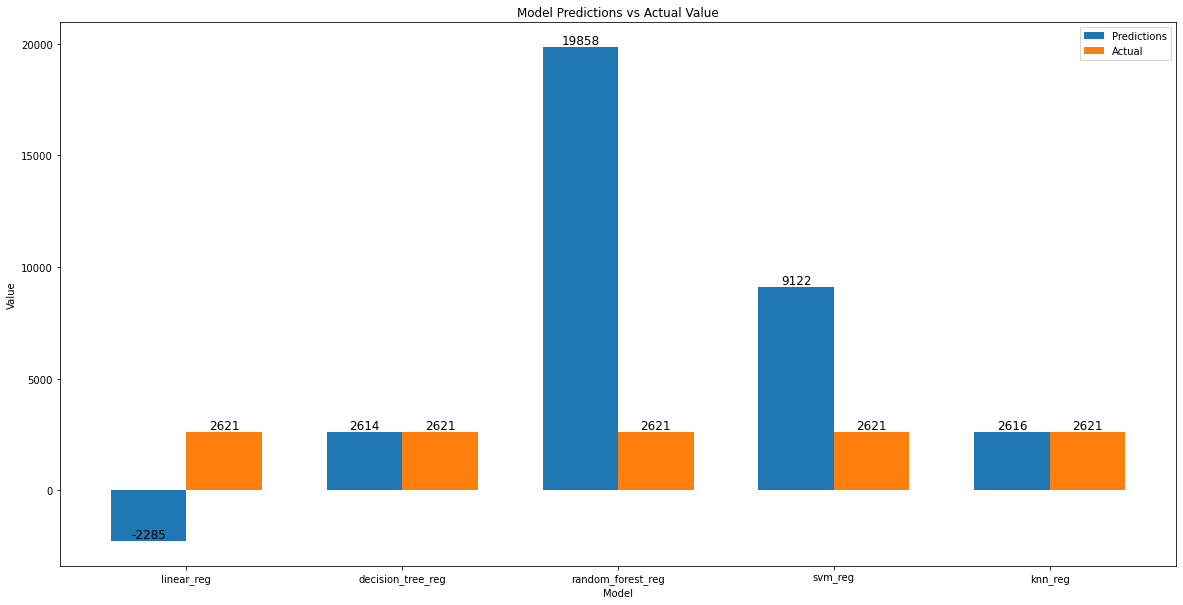

In [ ]:
plot_predictions(predictions, testY_values)

In [ ]:
# 将validation分成validationX和validationY
validationX = validation.iloc[:, :-1]
validationY = validation.iloc[:, -1]
# 将validationX和validationY的值分别赋值给validationX_values和validationY_values
validationX_values = validationX.values
validationY_values = validationY.values
print(validationX_values.shape)
print(validationY_values.shape)
print(validationX_values[0])
print(validationY_values[0])

(2000, 14)
(2000,)
[8.0 16.0 'None' 'CentOS Linux release 7.2 (Final)' 'None' None 'None'
 'None' 'None' '5.1.3a' 'default' 'None' 'None' 'gcc_oflag=O0,threads=1']
2576


In [ ]:
validationPredictions = getValidationPredictionsMulti(validationX_values, save_path, X, tempKey)

In [ ]:
def getModelScore(validationPredictions, validationY_values):
    modelScore = {}
    # 将validationPredictions的key赋值给modelScore,并将其值设置为0
    for key in validationPredictions.keys():
        modelScore[key] = 0

    for key in validationPredictions.keys():
        for i in range(len(validationPredictions[key])):
            # 判断每个模型的预测值与真实值的情况，判断条件：(1-abs(预测值-真实值)/真实值)*100%,如果大于等于90%，则加1
            if (1 - abs(validationPredictions[key][i] - validationY_values[i]) / validationY_values[i]) * 100 >= 90:
                modelScore[key] += 1

    return modelScore


def fromScoreDivideData(validationPredictions, bestModel, validationY_values):
    goodRows = []
    badRows = []
    absScore = []
    ABS = []
    for i in range(len(validationPredictions[bestModel])):
        if (1 - abs(validationPredictions[bestModel][i] - validationY_values[i]) / validationY_values[i]) * 100 > 90:
            goodRows.append(i)
        else:
            badRows.append(i)
        temp=(1 - abs(validationPredictions[bestModel][i] - validationY_values[i]) / validationY_values[i]) * 100
        temp = round(temp, 2)
        absScore.append(temp)
        ABS.append(abs(validationPredictions[bestModel][i] - validationY_values[i]))
    return goodRows, badRows, ABS, absScore

In [ ]:
modelScore= getModelScore(validationPredictions, validationY_values)

In [ ]:
bestModel = max(modelScore, key=modelScore.get)
goodRows, badRows, ABS, absScore = fromScoreDivideData(validationPredictions, bestModel, validationY_values)

In [ ]:
print(modelScore)

{'linear_reg': 740, 'decision_tree_reg': 1835, 'random_forest_reg': 67, 'svm_reg': 102, 'knn_reg': 953}


In [ ]:
# 在validation中新加一列，abs, 由abs(validation[your_field] - validationY_values)得到
validation['predict'] = validationPredictions[bestModel]
validation['abs'] = ABS
validation['absScore'] = absScore

# 将validation按照goodRows和badRows进行划分
goodDF = validation.iloc[goodRows, :]
badDF = validation.iloc[badRows, :]


print(goodDF.shape)
print(badDF.shape)

(1835, 18)
(165, 18)


In [ ]:
goodDF.head()

,cvm_cpu,cvm_memory,cvm_cpu_qos,cvm_os_type,cvm_cpu_type,cvm_version,cvm_gpu_type,host_cpu_type,host_memory_type,tool_version,component_version,host_manufacturer_name,host_type,results_key,#unixbench_cpu,predict,abs,absScore
6844,8.0,16.0,None,CentOS Linux release 7.2 (Final),None,None,None,None,None,5.1.3a,default,None,None,"gcc_oflag=O0,threads=1",2576,2613.913043,37.913043,98.53
14876,32.0,128.0,True,CentOS Linux release 8.2.2004 (Core),name_15,name_362,None,name_15,name_73,5.1.3a,default,name_3,None,"gcc_oflag=O0,threads=1,which_core_to_bind=0",3466,3467.000000,1.000000,99.97
21532,64.0,256.0,None,TencentOS Server 3.1 (Final),name_9,name_32,None,name_9,name_80,5.1.3a,529,name_108,None,"gcc_oflag=O0,threads=1",3016,3014.000000,2.000000,99.93
4031,84.0,152.0,False,CentOS Linux release 7.2 (Final),name_9,name_290,None,None,None,5.1.3,default,None,None,"gcc_oflag=O0,threads=1",2658,2650.000000,8.000000,99.70
18350,1.0,2.0,True,CentOS Linux release 7.6.1810 (Core),name_9,name_32,None,name_9,name_80,5.1.3a,default,name_108,None,"gcc_oflag=O0,threads=1",2543,2582.309859,39.309859,98.45


In [ ]:
# 将goodDF和badDF分别保存到goodData.csv和badData.csv
goodDF.to_csv(os.path.join(save_path, 'goodData.csv'), index=False)
badDF.to_csv(os.path.join(save_path, 'badData.csv'), index=False)

In [ ]:
# modelPath='model/unixbench/unixbench_cpu'
# # 根据模型的得分，选择最优的模型
# bestModel = max(modelScore, key=modelScore.get)
# print(bestModel)
# # 将modelPath文件夹下的模型删除，只保留最优的模型
# for model in os.listdir(modelPath):
#     if model.split('.')[0] == bestModel:
#         continue
#     else:
#         os.remove(os.path.join(modelPath, model))